### Notebook Utilities

In [2]:
!pip install einops moviepy
import pylab as pl
import numpy as np

import torch
import torch.nn.functional as F

from torchvision.transforms.functional import InterpolationMode

from torchvision.io import read_image, ImageReadMode
import torchvision.transforms as T
from einops import rearrange
from random import randint


from IPython.display import clear_output

import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter

torch.backends.cudnn.benchmark = False


def imread(filename: str, mode=ImageReadMode.RGB_ALPHA):
  image = read_image(filename, mode=mode).float()
  return image / 255


def to_rgb(image):
  image = torch.clip(image, 0, 1)
  return image[3] * image[:3] + (1-image[3])


def resize(image: torch.Tensor, width=40, height=40):
  transforms = T.Compose([
                          T.ToPILImage(),
                          T.Resize((width, height), InterpolationMode.NEAREST),
                          T.ToTensor()
  ])
  return transforms(image[:4])


def rescale(image: torch.Tensor, scale: int = 4):
  return T.Resize((image.shape[-2]*scale, image.shape[-1]*scale), T.InterpolationMode.NEAREST)(image)


def make_collage(images: torch.Tensor):
  return rearrange(images, 'b c h w -> c h (b w)')


def imshow(image: torch.Tensor):
  if len(image.size()) == 4:
    image = make_collage(image[:, :4])
  pl.imshow(image[:4].detach().cpu().permute(1,2,0))
  pl.axis('off')
  pl.show()


class VideoWriter:
  # class to make NCA evolution videos
  def __init__(self, filename='_autoplay.mp4', fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()
    if self.params['filename'] == '_autoplay.mp4':
      self.show()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))

  clear_output()

### NCA model

In [12]:
from torch import nn

class NCA(nn.Module):
  def __init__(self, n_channels=16):
    super().__init__()
    self.n_channels = n_channels
    self.layers = nn.Sequential(
          nn.Conv2d(n_channels, 256, kernel_size=3, padding=1, padding_mode="circular"),
          nn.ReLU(),
          nn.Conv2d(256, n_channels, kernel_size=1)
          )
    
    for name, param in self.named_parameters():
      if "2" in name:
          param.data.zero_()

  def wrap_edges(self, x: torch.Tensor) -> torch.Tensor:
    return F.pad(x, pad=(1, 1, 1, 1), mode='circular')

  def get_live_mask(self, x: torch.Tensor) -> torch.Tensor:
    return F.max_pool2d(self.wrap_edges(x), kernel_size=3, stride=1) > 0.1

  def stochastic_update(self, x: torch.Tensor) -> torch.Tensor:
    return (torch.rand(x.size(), device=x.device) < 0.5).float()

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return x + self.layers(x)# * self.stochastic_update(x)

  def evolve(self, x, n_steps: int) -> torch.Tensor:
    for _ in range(n_steps):
        x = self.forward(x)
    return x

### Training parameters

In [80]:
target_size = [62, 44]
padding = 4
n_channels = 24
padded_target_size = [size + 2*padding for size in target_size]
evolution_steps = [110, 220]
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

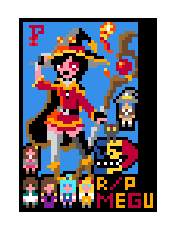

In [69]:
target = imread("megu.png") # You have to upload an image here
target = resize(target, *target_size)
target = T.Pad(padding)(target)
imshow(target)

### Train loop

In [70]:
def get_equispaced_points(start, finish, n_points):
  spacing = (finish - start) / n_points / 2
  return np.linspace(start, finish, n_points, endpoint=False) + spacing

In [71]:
def make_seed(n_images, n_channels, image_height, image_width, device="cpu"):
  seed = torch.zeros((n_images, n_channels, image_height, image_width), device=device)
  heights = get_equispaced_points(0, image_height, 1).astype(int)
  widths = get_equispaced_points(0, image_width, 1).astype(int)

  n = 4
  for h in heights:
    for w in widths:
      seed[:, n, h, w] = 1
      seed[:, 3, h, w] = 1
      n += 1

  return seed

def train_step(seed, target, optimizer, evolution_steps, criterion):
  optimizer.zero_grad()
  seed = nca.evolve(seed, evolution_steps[0])

  losses = torch.zeros((evolution_steps[1] - evolution_steps[0],), device=seed.device)
  for i in range(evolution_steps[1] - evolution_steps[0]):
    seed = nca(seed)
    losses[i] = criterion(seed[:, :4], target)

  loss = losses.mean()
  loss.backward()
  
  # Gradient normalization avoids exploding gradient issues
  with torch.no_grad():
    [param.grad.div_(torch.norm(param.grad) + 1e-8) for param in nca.parameters()]
  optimizer.step()

  return loss.item(), seed

In [35]:
# Initialize NCA
nca = NCA(n_channels).to(device)

In [81]:
pool_size = 512
batch_size = 1
resampled_images = 1
pool = make_seed(pool_size, n_channels, *padded_target_size, "cpu")
all_indices = np.arange(pool_size, dtype=int)

In [83]:
nca = torch.load("megu.pt")["nca"].to(device)

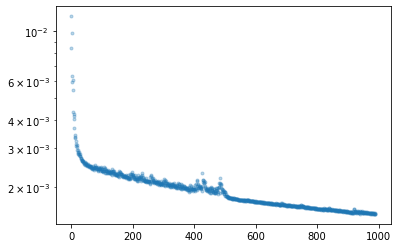

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


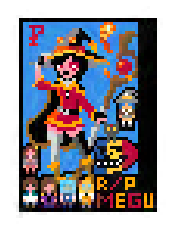

step: 990 loss: 0.0015136057045310736


In [84]:
#@title {vertical-output: true}
optimizer = torch.optim.Adam(nca.parameters(), lr=1e-4)
target = target.to(device)
criterion = nn.MSELoss()

nca.train()
losses = []
images = make_seed(resampled_images, n_channels, *padded_target_size, device)
for i in range(1000):
  # sampled_indices = np.random.choice(all_indices, batch_size, replace=False)
  # images = pool[sampled_indices].to(device)
  # images[:resampled_images] = make_seed(resampled_images, n_channels, *padded_target_size, device)
  loss, output = train_step(images, target, optimizer, evolution_steps, criterion)
  # pool[sampled_indices] = output.detach().cpu()
  losses.append(loss)

  if i%10 == 0:
    clear_output(wait=True)
    pl.plot(losses, '.', alpha=0.3)
    pl.yscale("log")
    pl.show()
    pl.figure(figsize = (16,4))
    imshow(output[:4].detach().cpu())
    print(f"step: {i} loss: {loss}", flush=True)

  if i == 500:
    for g in optimizer.param_groups:
      g['lr'] = 3e-5



In [92]:
torch.save({"nca": nca, "seed": make_seed(1, n_channels, *padded_target_size, "cpu")}, "megu.pt")

### Evolution Video

In [91]:
seed = make_seed(1, n_channels, *padded_target_size, device)

with torch.no_grad():
  with VideoWriter(fps=24) as vid:
    x = seed.clone()
    for i in range(24*8):
      frame = rescale(to_rgb(x[0]), 8).permute(1,2,0)
      vid.add(frame.cpu())
      x = nca(x)

## References

[1] Berto, Francesco and Jacopo Tagliabue, "Cellular Automata", The Stanford Encyclopedia of Philosophy (Spring 2022 Edition), Edward N. Zalta (ed.), forthcoming URL = <https://plato.stanford.edu/archives/spr2022/entries/cellular-automata/>. 

[2] Mordvintsev, et al., "Growing Neural Cellular Automata", Distill, 2020. URL = <https://distill.pub/2020/growing-ca/>

[3] William Gilpin, "Cellular automata as convolutional neural networks", arXiv, 2018. URL = <https://arxiv.org/abs/1809.02942>